In [2]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, KernelPCA

import torch
from torch.utils.data import DataLoader

from src.datasets.manifolds import SwissRoll, SCurve, Spheres

#from src.datasets.splitting import split_dataset

torch.manual_seed(42)
np.random.seed(42)

In [4]:
train=True
dataset = Spheres(train=train)

In [33]:
from src.evaluation.utils import get_space
from src.evaluation.eval import evaluate_space

batch_size = 64
# LOAD ALL MODELS AND GET SPACES

methods = ['toporeg', 'toporeg_vertex', 'toporeg_edge_oneway', 'toporeg_edge_symmetric', 'surrogate', 'vanilla'] #'surrogate'
datasets = ['spheres','swissroll', 'scurve'] # 'spheres',

#hard coded run ids:
##older runs: all 50 epochs
#run_ids = [2,4,5,6,12,7,8,9,10,11] #ids mapping above method+dataset to run directory
##newer runs: swissroll on 200 epochs:
#new_run_ids = [3,4,5,1,2] #for 200epochs..
#run_index = 0 # points to current run in run_ids
#path = '../runs/synthetic_experiments/{}/model.pth'
#new_path = '../runs/synthetic_experiments/200_epochs/{}/model.pth'
train=False #True False
path = '../exp_runs/train_model/synthetic_experiments/{}/model.pth'


# LOAD DATASETS:
datasets_ = {datasets[0]: Spheres(train=train), datasets[1]: SwissRoll(train=train), datasets[2]: SCurve(train=train)}
#datasets_ = {datasets[0]: SwissRoll(train=train), datasets[1]: SCurve(train=train)}

experiments = defaultdict(lambda: defaultdict(dict))
#Gathering all paths in one dict of dicts:
for dataset in datasets:
    
    #define dataloader:
    dataloader = DataLoader(datasets_[dataset], batch_size=batch_size, shuffle=False,
            pin_memory=True, drop_last=True)
    
    experiments[dataset]['data_space'], labels = get_space(None, dataloader, mode='data')
    if dataset == 'spheres':
        experiments[dataset]['labels'] = labels
    
    for method in methods:
        #init dict:
        #experiments[dataset][method] = {}
        
        #determine current model path:
        
        #older, hard-coded way:
        #if dataset == 'swissroll':
        #    curr_path = new_path.format(new_run_ids[run_index])
        #else:
        #    curr_path = path.format(run_ids[run_index])
        
        curr_path = path.format('_'.join([dataset,method]))
        model = torch.load(curr_path)
        
        #Keep path, model, and latent space in dict:
        experiments[dataset][method]['path'] = curr_path 
        experiments[dataset][method]['model'] = model
        
        latent, labels = get_space(model, dataloader, mode='latent')
        
        experiments[dataset][method]['latent'] = latent
        experiments[dataset][method]['labels'] = labels
 
        #Eval kNN properties:
        if dataset=='spheres':
            results = evaluate_space(latent, labels, k=15)
            experiments[dataset][method]['results'] = results
        
        
        ##run_index+=1

In [34]:
#Additional dim red methods for comparison:
import umap

dim_red_methods = ['pca','tsne', 'umap']
dim_red_dict = {'pca':PCA, 'tsne':TSNE, 'umap':umap.UMAP}
dim_red_Zs = []
for dataset in datasets:
    X = experiments[dataset]['data_space']
    for method in dim_red_methods:
        #if method == 'umap':
        #    Z = 
        #else:
        Z = dim_red_dict[method](random_state=42).fit_transform(X)
        experiments[dataset][method]['latent'] = Z



In [6]:
experiments['spheres']['toporeg'].keys()

dict_keys(['path', 'model', 'latent', 'labels', 'results'])

In [35]:
def plotting(transformed, all_labels, title):
    plt.scatter(transformed[:, 0], transformed[:, 1], c=all_labels, cmap=plt.cm.Spectral, alpha=0.4)
    plt.title(title)

def plott_all(dataset_name, X,labels, methods, all_Z):
    fig = plt.figure(1)
    
    subplot_count = 1
    h,w = 5,2
    ax = fig.add_subplot(h,w,subplot_count, projection="3d")
    
    #Plot Swiss Roll Data:
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.Spectral)

    plt.xticks([]), plt.yticks([])
    myfontsize = 18
    plt.title(dataset_name, fontsize=myfontsize)
    ax.set_xlabel('x', fontsize=myfontsize)
    ax.set_ylabel('y', fontsize=myfontsize)
    ax.set_zlabel('z', fontsize=myfontsize)
    fig.set_size_inches(12, 20)
    ax.view_init(5, 280) # rotation of the 3D plot
    plt.show()
    
    subplot_count+=1
    for method, latent in zip(methods, all_Z):
        #add subplots for latent spaces:
        print(subplot_count)
        ax = fig.add_subplot(h,w,subplot_count)
        plotting(latent, labels, f'2D Latent Space {method}')
        subplot_count += 1
 
    # hard-coded:
    #     ax = fig.add_subplot(322)
    #     plotting(all_Z[0], labels, f'2D Latent Space {methods[0]}')

    #     ax = fig.add_subplot(323)
    #     plotting(all_Z[1], labels, f'2D Latent Space {methods[1]}')

    #     ax = fig.add_subplot(324)
    #     plotting(all_Z[2], labels, f'2D Latent Space {methods[2]}')

    #     ax = fig.add_subplot(325)
    #     plotting(all_Z[3], labels, f'2D Latent Space {methods[3]}')

    #     ax = fig.add_subplot(326)
    #     plotting(all_Z[4], labels, f'2D Latent Space {methods[4]}')
    
    

<IPython.core.display.Javascript object>


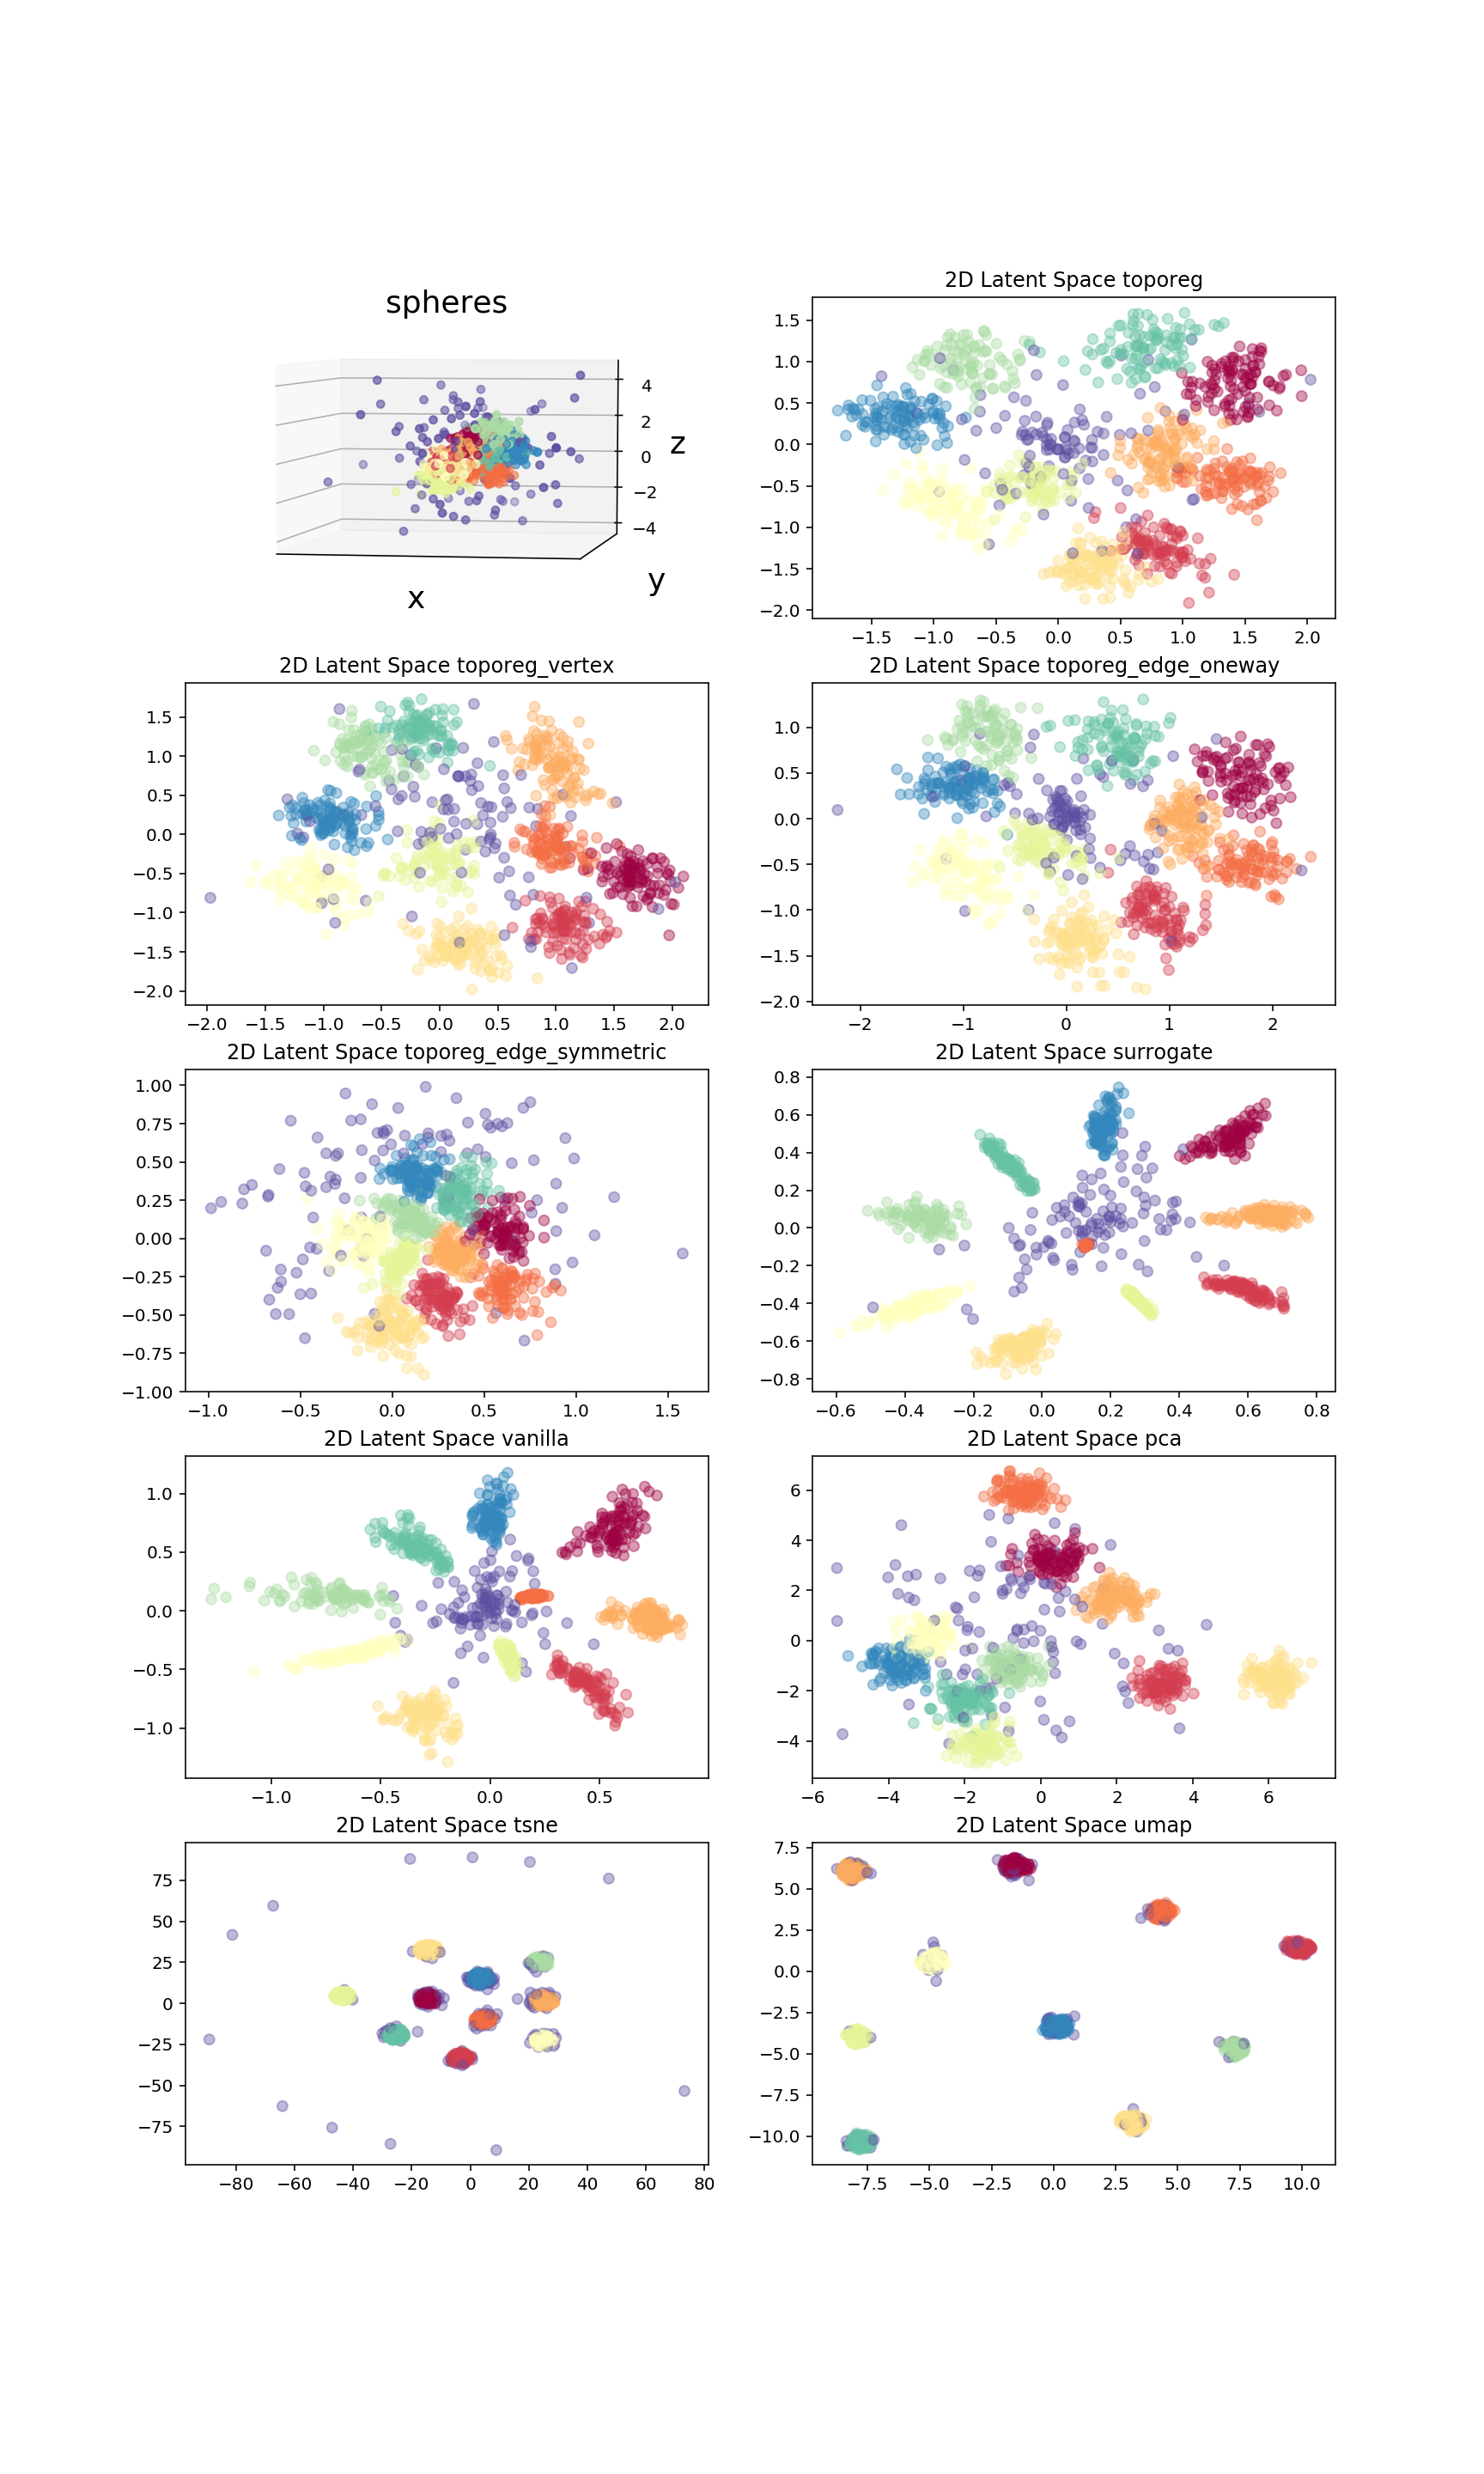

2
3
4
5
6
7
8
9
10


In [49]:
%matplotlib notebook

dataset= 'spheres' #'swissroll' #'scurve' #'spheres'
#methods = ['topo_pure', 'topo_vertex', 'topo_edge', 'surrogate', 'vanilla']
    
X = experiments[dataset]['data_space']
labels = experiments[dataset][methods[0]]['labels']

all_methods = methods + dim_red_methods
all_Z = [experiments[dataset][method]['latent'] for method in all_methods]

#Z2 = experiments[dataset][methods[4]]['latent']

plott_all(dataset, X, labels, all_methods, all_Z)
plt.savefig(f'200_epochs_{dataset}_train_{train}.png')

In [7]:
from  src.evaluation.knn_utils import get_k_predictions, get_NMI, get_acc

<IPython.core.display.Javascript object>


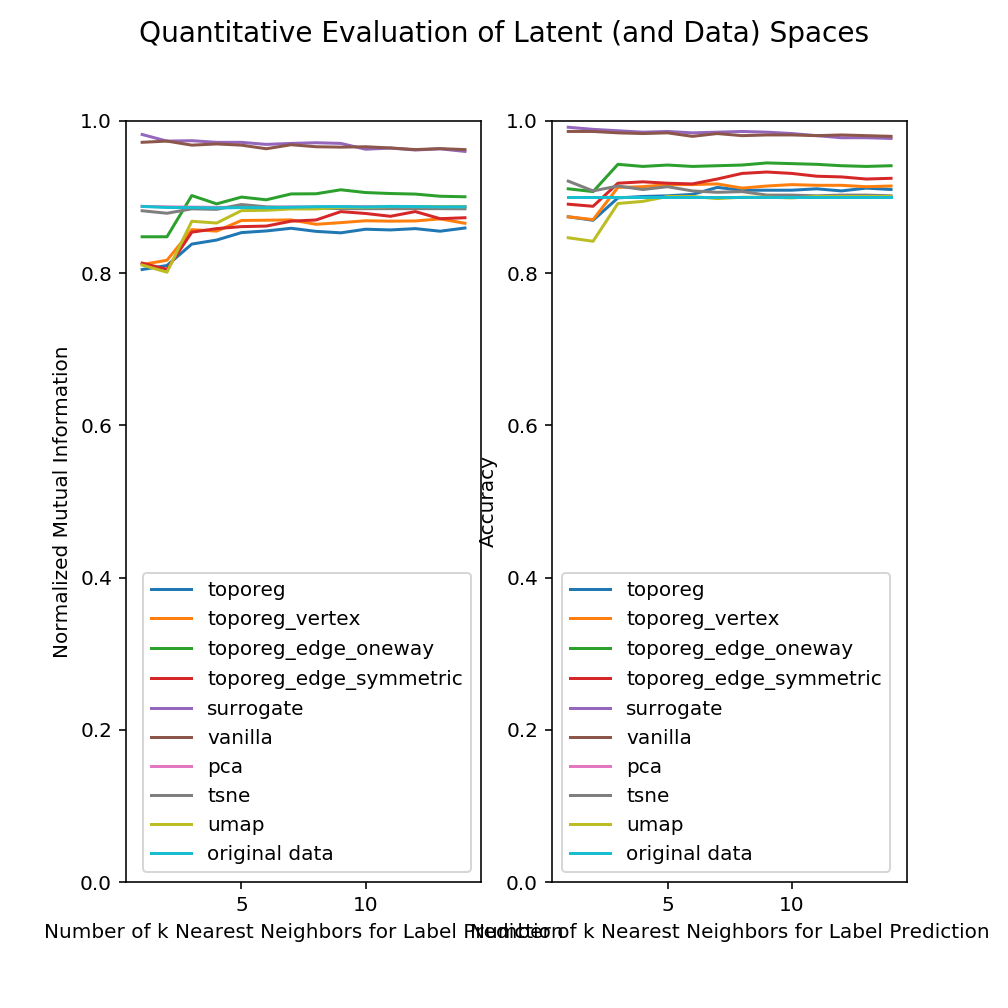

In [51]:
#for this cell, run above plot first!

def plot_scores(ax, method, embeddings, labels, metric, k=15):
    #first get predicted labels (based on up to k neighbors)
    k_preds = get_k_predictions(embeddings, labels, k=k)
    
    #for each int up to k get a NMI score of how well the neighborhood labels vote for the correct label
    scores = metric(k_preds, labels)
    ax.plot( np.arange(1,len(scores)+1), scores, label=method)

    return 

labels = experiments[dataset][methods[0]]['labels']


if len(all_Z) < 10: #only do this once when rerunning the cell
    all_methods = all_methods + ['original data']
    all_Z.append(X)

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(7, 7)
for ind, method in enumerate(all_methods):
    for ax, metric in zip( [ax1, ax2],[get_NMI,get_acc]):
        plot_scores(ax, method, all_Z[ind], labels, metric=metric, k=15)

ax1.set_ylim((0., 1)) 
ax1.set_ylabel('Normalized Mutual Information')
ax1.set_xlabel('Number of k Nearest Neighbors for Label Prediction')
ax1.legend(loc='lower right')
ax2.set_ylim((0., 1)) 
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Number of k Nearest Neighbors for Label Prediction')
ax2.legend(loc='lower right')

plt.legend()
f.suptitle(f"Quantitative Evaluation of Latent (and Data) Spaces", fontsize=14)

plt.savefig(f'spheres_scoring_train_{train}.pdf')


In [52]:
all_methods

['toporeg',
 'toporeg_vertex',
 'toporeg_edge_oneway',
 'toporeg_edge_symmetric',
 'surrogate',
 'vanilla',
 'pca',
 'tsne',
 'umap',
 'original data']

In [15]:
dataset

'spheres'

In [46]:
# import pickle

# exp_out = defaultdict(lambda: defaultdict(dict))

# for dataset in datasets:
#     exp_out[dataset]['data_space'] = experiments[dataset]['data_space']
#     for method in all_methods:
#         for item in experiments[dataset][method].keys():
#             if item != 'model':
#                 exp_out[dataset][method][item] = experiments[dataset][method][item] 

# with open('exp_out_train.pkl', 'wb') as handle:
#     pickle.dump(exp_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
                


PicklingError: Can't pickle <function <lambda> at 0x7f6318f139d8>: attribute lookup <lambda> on __main__ failed